In [8]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path

from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GroupKFold, cross_val_predict
from sklearn.metrics import cohen_kappa_score, roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 5)

In [9]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)


In [10]:
# Paths consistent with the rest of your project
TRAIN_PATH = "train_final.csv"
TEST_PATH  = "test_final.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("Train:", train.shape)
print("Test: ", test.shape)

TARGET_COL = "sii"
ID_CANDIDATES = ["id", "ID", "Id", "subject_id", "record_id"]

id_cols = [c for c in ID_CANDIDATES if c in train.columns]
feature_cols = [c for c in train.columns if c not in id_cols + [TARGET_COL]]

X = train[feature_cols].copy()
y = train[TARGET_COL].astype(int).values
X_test = test[feature_cols].copy()

n_classes = len(np.unique(y))
print("n_classes:", n_classes)


Train: (2736, 288)
Test:  (20, 287)
n_classes: 4


In [11]:
def qwk_metric(y_true, y_pred) -> float:
    """Quadratic Weighted Kappa."""
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")


def run_lgbm_cv(X, y, params, n_splits=5, random_state=42, sample_weight=None):
    """Standard 5-fold StratifiedKFold CV for quick QWK evaluation."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_pred = np.zeros(len(y), dtype=int)

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_trn, y_val = y[trn_idx], y[val_idx]

        w_fold = sample_weight[trn_idx] if sample_weight is not None else None

        model = LGBMClassifier(**params)
        model.fit(
            X_trn,
            y_trn,
            sample_weight=w_fold,
            eval_set=[(X_val, y_val)],
            eval_metric="multi_logloss",
        )

        val_proba = model.predict_proba(X_val)
        oof_pred[val_idx] = val_proba.argmax(axis=1)

        qwk = qwk_metric(y_val, oof_pred[val_idx])
        print(f"Fold {fold}: QWK={qwk:.4f}")

    qwk_full = qwk_metric(y, oof_pred)
    print(f"\nFull CV QWK: {qwk_full:.4f}")
    return qwk_full, oof_pred


## 1. Pseudo-Labeling the Unlabeled Actigraphy Data

### 1.1 Hard vs Soft Pseudo-Labels & One-Shot Strategy

**We use a one-shot pseudo-labeling approach** :

* Train a strong baseline model on labeled train

* Predict test probabilities

* Select only rows where max_proba ≥ threshold

* Append these rows to training data with hard labels (argmax)

Soft labels are more useful for NNs; for tree models, hard pseudo-labels usually work better and are simpler.

In [12]:
def fit_base_lgbm(X, y, params=None):
    if params is None:
        params = dict(
            objective="multiclass",
            num_class=n_classes,
            learning_rate=0.03,
            n_estimators=800,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=-1,
            random_state=42,
            n_jobs=-1
        )
    model = LGBMClassifier(**params)
    model.fit(X, y)
    return model, params


In [13]:
def pseudo_label_hard(model, X_train, y_train, X_unlabeled, threshold=0.7):
    """
    Hard pseudo-labeling:
    - model: fitted classifier with predict_proba
    - threshold: min confidence for accepting a pseudo-label
    """
    proba = model.predict_proba(X_unlabeled)
    conf = proba.max(axis=1)
    pseudo = proba.argmax(axis=1)

    mask = conf >= threshold
    X_pl = X_unlabeled[mask]
    y_pl = pseudo[mask]

    print(f"Accepted {mask.sum()} pseudo-labeled samples at threshold {threshold:.2f}")

    X_aug = pd.concat([X_train, X_pl], axis=0).reset_index(drop=True)
    y_aug = np.concatenate([y_train, y_pl])
    return X_aug, y_aug, conf, mask


### 1.2 QWK Monitoring vs Pseudo-Label Threshold

We scan multiple thresholds and plot QWK vs threshold to see where pseudo-labeling actually helps.

In [14]:
base_params = dict(
    objective="multiclass",
    num_class=n_classes,
    learning_rate=0.03,
    n_estimators=600,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

# Baseline CV QWK without pseudo-labeling
print("Baseline LGBM CV (no pseudo-labeling):")
baseline_qwk, baseline_oof = run_lgbm_cv(X, y, base_params)


Baseline LGBM CV (no pseudo-labeling):
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36496
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 277
[LightGBM] [Info] Start training from score -0.540042
[LightGBM] [Info] Start training from score -1.320842
[LightGBM] [Info] Start training from score -1.980316
[LightGBM] [Info] Start training from score -4.394906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [15]:
thresholds = [0.6, 0.7, 0.8, 0.9]
qwk_scores_pl = []

print("\nEvaluating pseudo-label thresholds:")
base_model, _ = fit_base_lgbm(X, y, base_params)

for th in thresholds:
    X_aug, y_aug, conf, mask = pseudo_label_hard(
        base_model, X, y, X_test, threshold=th
    )
    print(f"Running CV on augmented data (threshold={th:.2f})...")
    qwk_pl, _ = run_lgbm_cv(X_aug, y_aug, base_params)
    qwk_scores_pl.append(qwk_pl)
    print("-" * 40)



Evaluating pseudo-label thresholds:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37703
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 278
[LightGBM] [Info] Start training from score -0.540250
[LightGBM] [Info] Start training from score -1.321208
[LightGBM] [Info] Start training from score -1.979358
[LightGBM] [Info] Start training from score -4.387892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

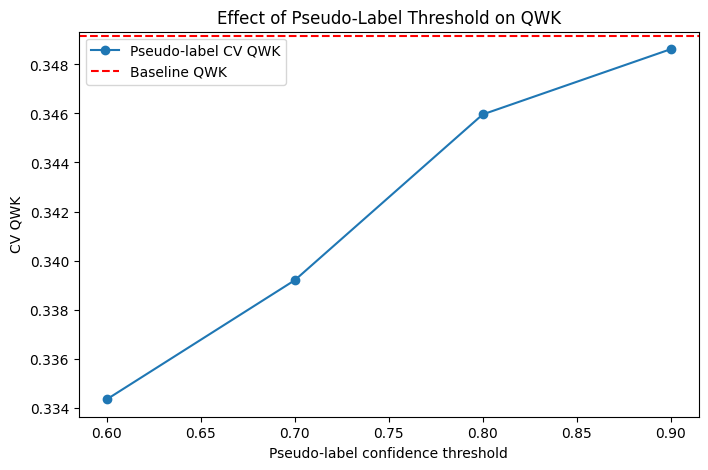

In [16]:
plt.figure()
plt.plot(thresholds, qwk_scores_pl, marker="o", label="Pseudo-label CV QWK")
plt.axhline(baseline_qwk, color="r", linestyle="--", label="Baseline QWK")
plt.xlabel("Pseudo-label confidence threshold")
plt.ylabel("CV QWK")
plt.title("Effect of Pseudo-Label Threshold on QWK")
plt.legend()
plt.show()


## 2. Adversarial Validation 2.0

Theory
Adversarial validation trains a model to distinguish train vs test rows. If the classifier is strong (AUC ≫ 0.5), it means heavy distribution shift, and we can downweight or remove train rows that look “too train-like” or “too test-unlike”.

### 2.1 Train vs Test Similarity Scoring

In [17]:
def adversarial_scores(train_df, test_df):
    df_train = train_df.copy()
    df_test = test_df.copy()
    df_train["__domain__"] = 0
    df_test["__domain__"] = 1

    df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)

    # Use all non-target numeric features
    drop_cols = [TARGET_COL, "__domain__"] + id_cols
    feat_cols = [c for c in df_all.columns if c not in drop_cols]
    X_adv = df_all[feat_cols]
    y_adv = df_all["__domain__"].values

    model_adv = LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model_adv.fit(X_adv, y_adv)

    adv_proba = model_adv.predict_proba(X_adv)[:, 1]
    auc = roc_auc_score(y_adv, adv_proba)
    print(f"Adversarial validation AUC (train vs test): {auc:.4f}")
    
    # Split back into train/test scores
    adv_train = adv_proba[:len(train_df)]
    adv_test = adv_proba[len(train_df):]
    return adv_train, adv_test, model_adv, feat_cols


[LightGBM] [Info] Number of positive: 20, number of negative: 2736
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37721
[LightGBM] [Info] Number of data points in the train set: 2756, number of used features: 278
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007257 -> initscore=-4.918520
[LightGBM] [Info] Start training from score -4.918520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

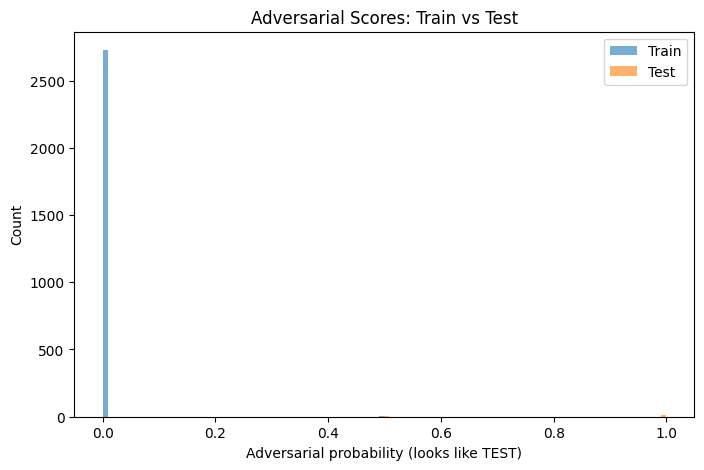

In [18]:
adv_train_scores, adv_test_scores, adv_model, adv_features = adversarial_scores(train, test)

plt.figure()
plt.hist(adv_train_scores, bins=50, alpha=0.6, label="Train")
plt.hist(adv_test_scores, bins=50, alpha=0.6, label="Test")
plt.xlabel("Adversarial probability (looks like TEST)")
plt.ylabel("Count")
plt.title("Adversarial Scores: Train vs Test")
plt.legend()
plt.show()


### 2.2 Use Adversarial Scores as Sample Weights / Filtering

- Two options:

Sample weighting: downweight “too train-like” rows

Filtering: remove extreme outliers

In [19]:
def make_adv_sample_weights(adv_train_scores, min_weight=0.1):
    """
    Higher weight for rows that look more like test.
    adv_train_scores ~ P(domain=1 | x) from adversarial model.
    """
    weights = adv_train_scores.copy()
    # Normalize to [min_weight, 1]
    w = (weights - weights.min()) / (weights.max() - weights.min() + 1e-8)
    w = min_weight + (1 - min_weight) * w
    return w

adv_weights = make_adv_sample_weights(adv_train_scores)

print("Training LGBM with adversarial sample weights:")
qwk_adv, _ = run_lgbm_cv(X, y, base_params, sample_weight=adv_weights)


Training LGBM with adversarial sample weights:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36496
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 277
[LightGBM] [Info] Start training from score -0.533723
[LightGBM] [Info] Start training from score -1.349227
[LightGBM] [Info] Start training from score -1.950888
[LightGBM] [Info] Start training from score -4.423353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

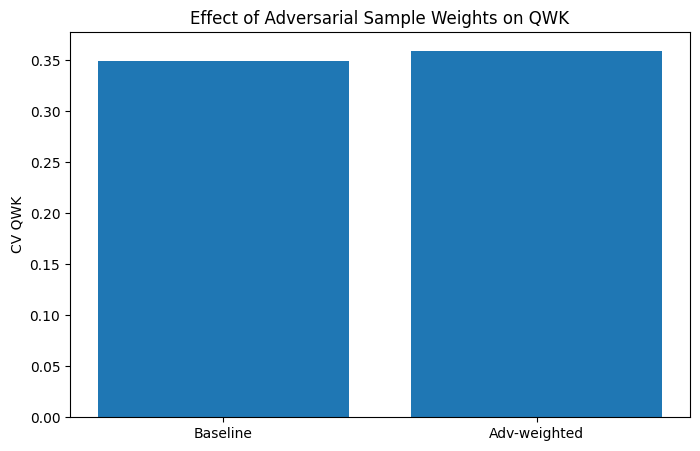

In [20]:
plt.figure()
bar_x = ["Baseline", "Adv-weighted"]
bar_y = [baseline_qwk, qwk_adv]
plt.bar(bar_x, bar_y)
plt.ylabel("CV QWK")
plt.title("Effect of Adversarial Sample Weights on QWK")
plt.show()


## 3. Target Permutation & Leakage Testing
- Theory
If there is any hidden leakage (e.g., test stats, target reused in features), a model trained on a permuted target can still achieve a suspiciously high QWK. A clean pipeline should drop to ~0 QWK.

### 3.1 Ready Script for Permutation Test

In [21]:
def permutation_leakage_test(model_cls, params, X, y, n_permutations=3, n_splits=5):
    true_qwk, _ = run_lgbm_cv(X, y, params, n_splits=n_splits)
    perm_qwks = []

    print("\nRunning permutation tests:")
    for i in range(n_permutations):
        y_perm = np.random.permutation(y)
        print(f"\nPermutation {i+1}/{n_permutations}")
        qwk_perm, _ = run_lgbm_cv(X, y_perm, params, n_splits=n_splits)
        perm_qwks.append(qwk_perm)

    perm_qwks = np.array(perm_qwks)
    print(f"\nTrue QWK: {true_qwk:.4f}")
    print("Permutation QWKs:", perm_qwks.round(4))
    print(f"Mean permuted QWK: {perm_qwks.mean():.4f}")

    return true_qwk, perm_qwks


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36496
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 277
[LightGBM] [Info] Start training from score -0.540042
[LightGBM] [Info] Start training from score -1.320842
[LightGBM] [Info] Start training from score -1.980316
[LightGBM] [Info] Start training from score -4.394906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

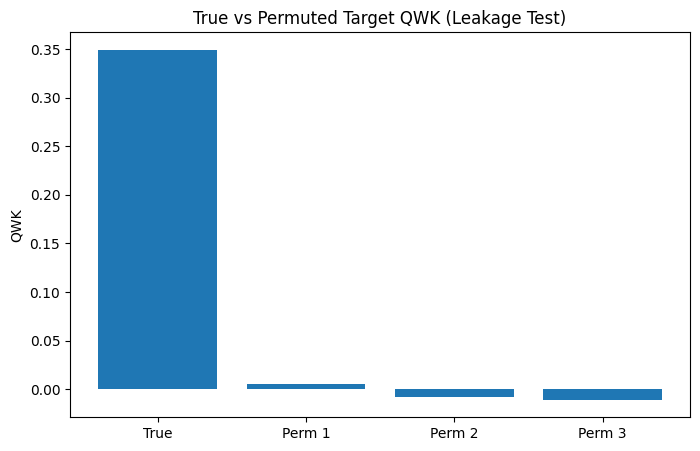

In [22]:
true_qwk, perm_qwks = permutation_leakage_test(LGBMClassifier, base_params, X, y, n_permutations=3)

plt.figure()
plt.bar(["True"] + [f"Perm {i+1}" for i in range(len(perm_qwks))],
        [true_qwk] + perm_qwks.tolist())
plt.ylabel("QWK")
plt.title("True vs Permuted Target QWK (Leakage Test)")
plt.show()


## 4. Hill-Climbing Ensemble (Post-Processing)
Theory
QWK is piecewise and ordinal; naive argmax on probabilities is suboptimal, we can slightly tweak predictions via hill-climbing or small local search.

### 4.1 Generic Hill-Climbing Optimizer

In [23]:
def hill_climb_qwk(y_true, proba, n_iter=3000, seed=42):
    """
    Simple hill-climbing on discrete predictions to maximize QWK.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_classes = proba.shape
    preds = proba.argmax(axis=1)
    best_preds = preds.copy()
    best_qwk = qwk_metric(y_true, best_preds)

    for it in range(n_iter):
        idx = rng.randint(0, n_samples)
        new_class = rng.randint(0, n_classes)
        old_class = best_preds[idx]
        if new_class == old_class:
            continue

        best_preds[idx] = new_class
        qwk_new = qwk_metric(y_true, best_preds)
        if qwk_new > best_qwk:
            best_qwk = qwk_new
        else:
            best_preds[idx] = old_class  # revert

        if (it + 1) % 500 == 0:
            print(f"Iter {it+1}/{n_iter} - Best QWK: {best_qwk:.4f}")

    return best_preds, best_qwk


### 4.2 Use Hill-Climb on OOF + Visualize Improvement

In [24]:
# Example: load strong model OOF predictions (shape: [n_samples, n_classes])
if Path("oof_catboost.npy").exists():
    oof_cat_proba = np.load("oof_catboost.npy")
    base_pred = oof_cat_proba.argmax(axis=1)
    base_qwk = qwk_metric(y, base_pred)
    print(f"Base CatBoost QWK (OOF): {base_qwk:.4f}")

    hc_pred, hc_qwk = hill_climb_qwk(y, oof_cat_proba, n_iter=3000, seed=42)
    print(f"Hill-Climbed QWK: {hc_qwk:.4f}")

    plt.figure()
    plt.bar(["Base", "Hill-Climbed"], [base_qwk, hc_qwk])
    plt.ylabel("QWK")
    plt.title("Effect of Hill-Climbing on QWK (OOF)")
    plt.show()
else:
    print("oof_catboost.npy not found - run your final modeling notebook to generate OOF preds.")


oof_catboost.npy not found - run your final modeling notebook to generate OOF preds.


## 5. Neural Network on Actigraphy Aggregates
A small MLP can capture smooth nonlinear patterns in actigraphy aggregates that trees sometimes miss.

### 5.1 Build an Actigraphy Feature Subset

In [25]:
def select_actigraphy_features(df, candidates=None):
    if candidates is not None:
        return [c for c in df.columns if c in candidates]
    # heuristic: columns with these substrings
    keywords = ["act", "ACT", "enmo", "ENMO", "accel", "ACC"]
    act_cols = [c for c in df.columns
                if any(kw in c for kw in keywords)
                and c not in id_cols + [TARGET_COL]]
    # fallback: use all features if we find nothing
    if len(act_cols) == 0:
        act_cols = [c for c in df.columns if c not in id_cols + [TARGET_COL]]
    return act_cols

act_cols = select_actigraphy_features(train)
print(f"Using {len(act_cols)} actigraphy-related features for NN.")


Using 27 actigraphy-related features for NN.


### 5.2 Minimal PyTorch Dataset & MLP Model

In [26]:
class TabDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.X[idx], self.y[idx]  # (input, noised_input, target)


In [27]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.net(x)


### 5.3 Training Loop with Early Stopping & QWK Callback

In [28]:
def train_nn_fold(X_trn, y_trn, X_val, y_val, n_classes, 
                  n_epochs=30, batch_size=64, lr=1e-3, noise_std=0.0):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = MLP(X_trn.shape[1], n_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_ds = TabDataset(X_trn, y_trn)
    val_ds = TabDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

    best_qwk = -1
    best_state = None
    patience = 5
    wait = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        for xb, xb_noised, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            if noise_std > 0:
                xb = xb + torch.randn_like(xb) * noise_std

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # evaluation
        model.eval()
        val_preds = []
        val_trues = []
        with torch.no_grad():
            for xb, xb_noised, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb)
                preds = logits.argmax(1).cpu().numpy()
                val_preds.extend(preds)
                val_trues.extend(yb.numpy())

        qwk = qwk_metric(np.array(val_trues), np.array(val_preds))
        print(f"Epoch {epoch}: val QWK={qwk:.4f}")

        if qwk > best_qwk:
            best_qwk = qwk
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_state)
    return model, best_qwk


### 5.4 Single-Fold Demo & Visualization

In [29]:
skf_nn = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
trn_idx, val_idx = next(skf_nn.split(train[act_cols], y))

X_trn_nn = train.iloc[trn_idx][act_cols]
y_trn_nn = y[trn_idx]
X_val_nn = train.iloc[val_idx][act_cols]
y_val_nn = y[val_idx]

print("Training NN on actigraphy subset...")
nn_model, nn_best_qwk = train_nn_fold(
    X_trn_nn, y_trn_nn, X_val_nn, y_val_nn, 
    n_classes=n_classes, noise_std=0.002
)

print(f"Best NN QWK (single fold): {nn_best_qwk:.4f}")


Training NN on actigraphy subset...
Epoch 1: val QWK=-0.0006
Epoch 2: val QWK=0.0000
Epoch 3: val QWK=0.0606
Epoch 4: val QWK=0.0307
Epoch 5: val QWK=0.0275
Epoch 6: val QWK=0.0170
Epoch 7: val QWK=0.1534
Epoch 8: val QWK=0.1116
Epoch 9: val QWK=0.1591
Epoch 10: val QWK=0.1338
Epoch 11: val QWK=0.1336
Epoch 12: val QWK=0.1328
Epoch 13: val QWK=0.0489
Epoch 14: val QWK=0.1581
Early stopping triggered.
Best NN QWK (single fold): 0.1591


## 6. Stacking / Blending Masterclass

### 6.1 Load Level-1 OOF & Test Predictions

In [30]:
def load_oof_test_pairs():
    oof_files = sorted(Path(".").glob("oof_*.npy"))
    test_files = sorted(Path(".").glob("test_*.npy"))

    oofs = []
    tests = []
    names = []

    for oof_f in oof_files:
        name = oof_f.stem.replace("oof_", "")
        test_f = Path(f"test_{name}.npy")
        if not test_f.exists():
            continue
        oof = np.load(oof_f)
        test_pred = np.load(test_f)
        oofs.append(oof)
        tests.append(test_pred)
        names.append(name)

    print("Found base models:", names)
    return oofs, tests, names

oof_list, test_list, model_names = load_oof_test_pairs()


Found base models: []


### 6.2 Simple Weighted Blending Search

In [31]:
def evaluate_blend(weights, oof_list, y_true):
    blended = np.zeros_like(oof_list[0])
    for w, oof in zip(weights, oof_list):
        blended += w * oof
    preds = blended.argmax(axis=1)
    return qwk_metric(y_true, preds), blended

def random_weight_search(oof_list, y_true, n_trials=500, seed=42):
    rng = np.random.RandomState(seed)
    n_models = len(oof_list)
    best_qwk = -1
    best_w = None
    best_blend = None

    for i in range(n_trials):
        w = rng.dirichlet(alpha=np.ones(n_models))
        qwk, blended = evaluate_blend(w, oof_list, y_true)
        if qwk > best_qwk:
            best_qwk = qwk
            best_w = w
            best_blend = blended
        if (i + 1) % 100 == 0:
            print(f"Trial {i+1}/{n_trials} - Best QWK so far: {best_qwk:.4f}")

    return best_qwk, best_w, best_blend


In [32]:
if len(oof_list) > 0:
    best_qwk_blend, best_weights, best_blended_oof = random_weight_search(oof_list, y, n_trials=500)
    print("\nBest blended QWK:", best_qwk_blend)
    print("Best weights:", dict(zip(model_names, best_weights)))

    # Visualize improvement vs best single
    single_qwks = []
    for name, oof in zip(model_names, oof_list):
        qwk_single = qwk_metric(y, oof.argmax(axis=1))
        single_qwks.append(qwk_single)
        print(f"{name}: {qwk_single:.4f}")

    plt.figure()
    plt.bar(model_names + ["Blend"], single_qwks + [best_qwk_blend])
    plt.xticks(rotation=45)
    plt.ylabel("QWK")
    plt.title("Single-Model vs Blended QWK (OOF)")
    plt.show()
else:
    print("No OOF/test predictions found for blending.")


No OOF/test predictions found for blending.


## 7. Seasonal & Device Stratification

### 7.1 Custom Stratification Key

In [33]:
def make_strat_key(df, target_col=TARGET_COL, season_col="Season", device_col="DeviceType"):
    target = df[target_col].astype(str)
    season = df[season_col].astype(str) if season_col in df.columns else "NA"
    device = df[device_col].astype(str) if device_col in df.columns else "NA"
    return (target + "_" + season + "_" + device)


In [34]:
def stratified_cv_with_metadata(train_df, n_splits=5, random_state=42):
    if "Season" not in train_df.columns and "DeviceType" not in train_df.columns:
        print("Season/DeviceType not found. Falling back to plain StratifiedKFold.")
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        keys = train_df[TARGET_COL].values
    else:
        print("Using custom stratification with Season/DeviceType metadata.")
        keys = make_strat_key(train_df)

        # collapse rare keys if needed
        vc = pd.Series(keys).value_counts()
        rare = vc[vc < 3].index
        keys = np.where(pd.Series(keys).isin(rare), train_df[TARGET_COL].astype(str).values, keys)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, keys), 1):
        print(f"Fold {fold}: train={len(trn_idx)}, val={len(val_idx)}")
    return skf


## 8. Feature Diffusion / Denoising

### 8.1 Diffusion Function & Integration with LGBM

In [35]:
def diffuse_features(X, noise_std=0.002, random_state=42):
    rng = np.random.RandomState(random_state)
    X_noisy = X.copy()
    noise = rng.normal(loc=0.0, scale=noise_std, size=X.shape)
    X_noisy = X_noisy + noise
    return X_noisy


In [38]:
def run_lgbm_cv_diffused(X, y, params, n_splits=5, random_state=42, noise_std=0.002):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_pred = np.zeros(len(y), dtype=int)

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_trn, y_val = y[trn_idx], y[val_idx]

        X_trn_noisy = diffuse_features(X_trn, noise_std=noise_std, random_state=random_state + fold)

        model = LGBMClassifier(**params)
        model.fit(
            X_trn_noisy,
            y_trn,
            eval_set=[(X_val, y_val)],
            eval_metric="multi_logloss",
        )

        val_proba = model.predict_proba(X_val)
        oof_pred[val_idx] = val_proba.argmax(axis=1)
        qwk = qwk_metric(y_val, oof_pred[val_idx])
        print(f"Fold {fold}: QWK={qwk:.4f}")

    qwk_full = qwk_metric(y, oof_pred)
    print(f"\nFull CV QWK with diffusion: {qwk_full:.4f}")
    return qwk_full, oof_pred


Comparing baseline vs diffused features:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73185
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 287
[LightGBM] [Info] Start training from score -0.540042
[LightGBM] [Info] Start training from score -1.320842
[LightGBM] [Info] Start training from score -1.980316
[LightGBM] [Info] Start training from score -4.394906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

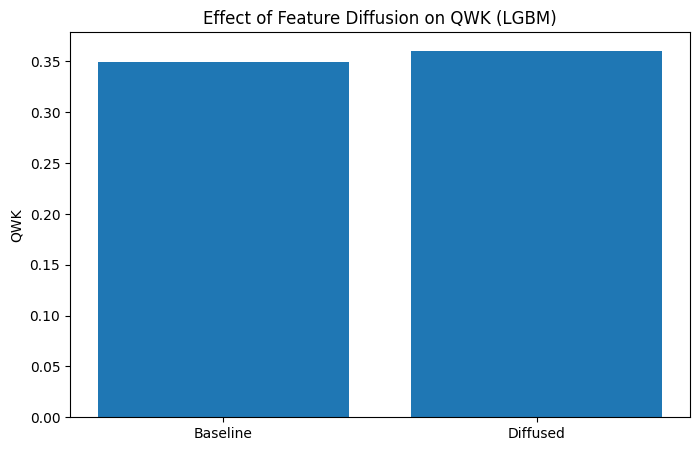

In [39]:
print("Comparing baseline vs diffused features:")
qwk_diffused, _ = run_lgbm_cv_diffused(X, y, base_params, noise_std=0.002)

plt.figure()
plt.bar(["Baseline", "Diffused"], [baseline_qwk, qwk_diffused])
plt.ylabel("QWK")
plt.title("Effect of Feature Diffusion on QWK (LGBM)")
plt.show()
